# Time Series Analysis Coursework

#### Alexander Juxon Cobb, 01713494

#### 17/12/2021

In this notebook I will explore the accuracy of different spectral density estimation methods, optimisation of AR(p) models via different generation procedures and the effectiveness of an AR(p) model in forecasting my given time series.

## Question 1

1a

In [38]:
from math import cos, pi
from cmath import exp

def S_ARMA(f, phis, thetas, sigma2):
    p = len(phis)
    q = len(thetas)
    sdfs = []
    for freq in f: # Calculate the spectral density function at each frequency given.
        sum_thetas = 1 # Initialising the numerator of the ARMA(p, q) sdf formula.
        for i in range(q):
            sum_thetas -= thetas[i] * exp(-1j*2*pi*freq*(i+1)) # Using the formula presented in lectures, accounting for python indexing.
        sum_phis = 1 # Initialising the denominator.
        for i in range(p):
            sum_phis -= phis[i] * exp(-1j*2*pi*freq*(i+1))
        sdf = sigma2 * abs(sum_thetas)**2/abs(sum_phis)**2 # Putting the numerator and denominator together to calculate the sdf.
        sdfs.append(sdf)
    return sdfs

1b

In [39]:
import numpy as np
from math import sqrt

def ARMA22_sim(phis, thetas, sigma2, N):
    x_t_minus_1, x_t_minus_2 = 0, 0 # Initialise previous values of Xt.
    epsilons = [np.random.normal(0, sqrt(sigma2)), np.random.normal(0, sqrt(sigma2)), np.random.normal(0, sqrt(sigma2))] # Initialise white noise values.
    X = []
    for i in range(100 + N): # We use 100 + N to implement the 'burn in'.
        x_t = phis[0]*x_t_minus_1 + phis[1]*x_t_minus_2 + epsilons[0] - thetas[0]*epsilons[1] - thetas[1]*epsilons[2] # Using the ARMA(2, 2) formula.
        X.append(x_t)
        epsilons = [np.random.normal(0, sqrt(sigma2)), epsilons[0], epsilons[1]] # Update the white noise values.
        x_t_minus_2 = x_t_minus_1 # Update the previous values of Xt.
        x_t_minus_1 = x_t
    return X[100:100+N]

1c

In [40]:
import scipy as sp
from math import floor

def periodogram(X):
    N = len(X)
    y = sp.fft.fft(X) # Using fft as suggested in the question sheet.
    periodogram = [(abs(i)**2)/N for i in y] # Using the formula for a periodogram.
    return periodogram

def direct(X, p):
    N = len(X)
    pN_floor = floor(p*N) 
    h = []
    for i in range(1, floor(pN_floor/2) + 1): # Accounting for python indexing.
        h.append(1/2 * (1 - cos((2*pi*(i))/(pN_floor + 1)))) # Using the formula presented in lectures.
    for i in range(floor(pN_floor/2) + 1, N + 1 - floor(pN_floor/2)):
        h.append(1) # as 1 * C
    for i in range(N + 1 - floor(pN_floor/2), N + 1):
        h.append(1/2 * (1 - cos((2*pi*(N+1-i))/(pN_floor + 1))))
    
    sum_h_squared = sum(i*i for i in h)
    h = [i/sqrt(sum_h_squared) for i in h] # Normalise to ensure sum(h^2) = 1, as required.
    
    hX = []
    for i, j in zip(h, X):
        hX.append(i*j) # Create the vector of products.
    
    y = sp.fft.fft(hX)
    direct = [(abs(i)**2) for i in y]
    return direct

1dA

In [45]:
f_prime = 12/128

def sample_bias_func(r):

    simulations = []
    for i in range(10000):
        simulations.append(ARMA22_sim([2*r*cos(2*pi*f_prime), -r**2], [-0.5, -0.2], 1, 128)) # Using the simulation function above.

    periodograms = []
    cosine_tapers = []

    for simulation in simulations:
        periodogram_simulation = periodogram(simulation)
        taper_05 = direct(simulation, 0.05)
        taper_10 = direct(simulation, 0.10)
        taper_25 = direct(simulation, 0.25)
        taper_50 = direct(simulation, 0.50)
        
        # Using 11, 31, 59 to account for python's indexing.
        periodograms.append([periodogram_simulation[11], 
                             periodogram_simulation[31], 
                             periodogram_simulation[59]])


        cosine_tapers.append([[taper_05[11], taper_05[31], taper_05[59]], 
                              [taper_10[11], taper_10[31], taper_10[59]], 
                              [taper_25[11], taper_25[31], taper_25[59]],
                              [taper_50[11], taper_50[31], taper_50[59]]])

    actual_sdf = S_ARMA([12/128, 32/128, 60/128], [2*r*cos(2*pi*f_prime), -r**2], [-0.5, -0.2], 1)

    taper_estimates = []
    for i in range(3): # I.e. 12, 32, 64
        for j in range(4): # I.e. 0.05, 0.10, 0.25, 0.50
            estimate = 0
            for k in range(len(cosine_tapers)): # I.e. all 10000 simulations.
                estimate += cosine_tapers[k][j][i] # Will have each frequency together.
            taper_estimates.append(estimate/len(cosine_tapers)) # Divide by 10000 to get the mean.

    taper_bias = []
    for i in range(len(taper_estimates)):
        if i <= 3:
            taper_bias.append(taper_estimates[i] - actual_sdf[0]) # We know that bias = expectation - actual.
        elif i >= 4 and i <= 7:
            taper_bias.append(taper_estimates[i] - actual_sdf[1])
        else:
            taper_bias.append(taper_estimates[i] - actual_sdf[2])

    periodogram_estimates = []
    for i in range(3):
        estimate = 0
        for j in range(len(periodograms)):
            estimate += periodograms[j][i]
        periodogram_estimates.append(estimate/len(periodograms))

    periodogram_bias = []
    for i in range(3):
        periodogram_bias.append(periodogram_estimates[i] - actual_sdf[i])
    
    return [[round(num, 3) for num in periodogram_bias], [round(num, 3) for num in taper_bias]]

1dB

In [50]:
print(f"The biases for the periodogram estimate, at frequencies 12/128, 32/128 and 60/128 are {sample_bias_func(0.8)[0]} \n")
print(f"The biases for the taper estimate, at frequencies 12/128, 32/128 and 60/128 and for a cosine taper of 0.05 are {sample_bias_func(0.8)[1][0:3]} \n")
print(f"The biases for the taper estimate, at frequencies 12/128, 32/128 and 60/128 and for a cosine taper of 0.10 are {sample_bias_func(0.8)[1][3:6]} \n")
print(f"The biases for the taper estimate, at frequencies 12/128, 32/128 and 60/128 and for a cosine taper of 0.25 are {sample_bias_func(0.8)[1][6:9]} \n")
print(f"The biases for the taper estimate, at frequencies 12/128, 32/128 and 60/128 and for a cosine taper of 0.50 are {sample_bias_func(0.8)[1][9:12]} \n")

The biases for the periodogram estimate, at frequencies 12/128, 32/128 and 60/128 are [1.885, 0.241, 0.052] 

The biases for the taper estimate, at frequencies 12/128, 32/128 and 60/128 and for a cosine taper of 0.05 are [0.758, 1.024, 1.494] 

The biases for the taper estimate, at frequencies 12/128, 32/128 and 60/128 and for a cosine taper of 0.10 are [2.306, 0.168, 0.126] 

The biases for the taper estimate, at frequencies 12/128, 32/128 and 60/128 and for a cosine taper of 0.25 are [0.109, 0.105, 0.001] 

The biases for the taper estimate, at frequencies 12/128, 32/128 and 60/128 and for a cosine taper of 0.50 are [0.0, 0.0, 0.0] 



We can see that, in general, tapering reduces the bias of the spectral density estimate. In addition, as we might expect, the 50% cosine taper is the best estimate due to its reduction of side-lobe leakage.

1dC

In [6]:
rs = [i/100 for i in range(81, 100)]
biases = []

for r in rs:
    biases.append(sample_bias_func(r)[1])

1dD

Text(0, 0.5, 'bias')

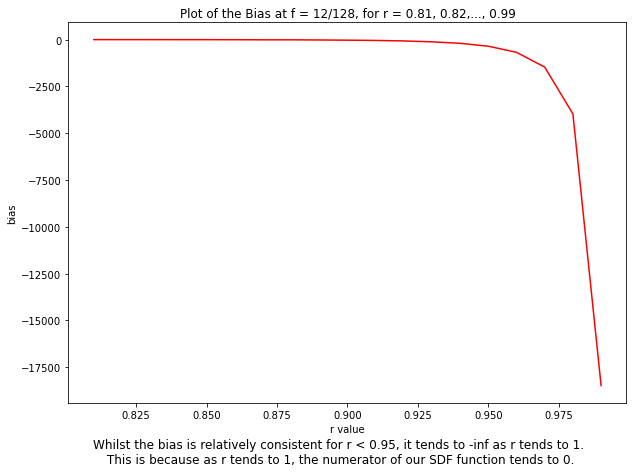

In [246]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

plt.plot([i/100 for i in range(81, 100)], 
         [(biases[i][0] + biases[i][1] + biases[i][2] + biases[i][3])/4 for i in range(len(biases))], 
         color = 'red') # Averaged over the 4 tapers to avoid the influence of anomolies.
plt.title('Plot of the Bias at f = 12/128, for r = 0.81, 0.82,..., 0.99')
plt.figtext(0.5, 0.01, 'Whilst the bias is relatively consistent for r < 0.95, it tends to -inf as r tends to 1.'
                       '\n This is because as r tends to 1, the numerator of our SDF function tends to 0.', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.xlabel('r value')
plt.ylabel('bias')


Text(0, 0.5, 'bias')

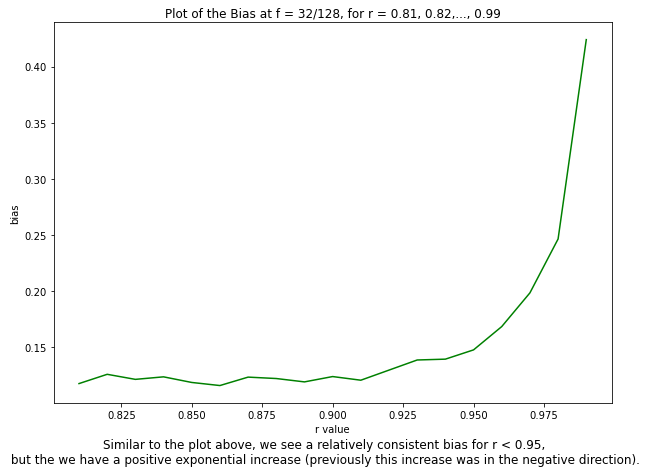

In [248]:
plt.figure(figsize=(10, 7))

plt.plot([i/100 for i in range(81, 100)], 
         [(biases[i][4] + biases[i][5] + biases[i][6] + biases[i][7])/4 for i in range(len(biases))], 
         color = 'green')
plt.title('Plot of the Bias at f = 32/128, for r = 0.81, 0.82,..., 0.99')
plt.figtext(0.5, 0.01, 'Similar to the plot above, we see a relatively consistent bias for r < 0.95,'
                       '\n but the we have a positive exponential increase (previously this increase was in the negative direction).', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.xlabel('r value')
plt.ylabel('bias')

Text(0, 0.5, 'bias')

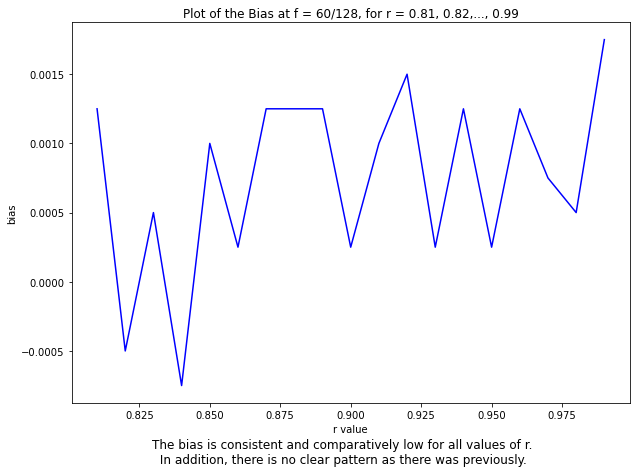

In [249]:
plt.figure(figsize=(10, 7))

plt.plot([i/100 for i in range(81, 100)], 
         [(biases[i][8] + biases[i][9] + biases[i][10] + biases[i][11])/4 for i in range(len(biases))], 
         color = 'blue')
plt.title('Plot of the Bias at f = 60/128, for r = 0.81, 0.82,..., 0.99')
plt.figtext(0.5, 0.01, 'The bias is consistent and comparatively low for all values of r.'
                       '\n In addition, there is no clear pattern as there was previously.', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.xlabel('r value')
plt.ylabel('bias')

1e

Estimate for the variance of the process = 12.081


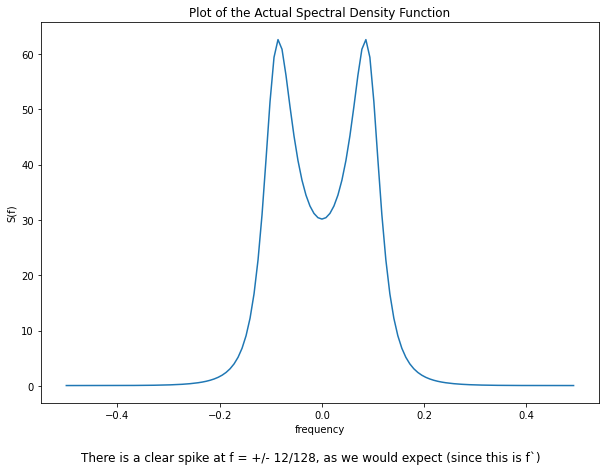

In [99]:
r = 0.8

plt.figure(figsize=(10, 7))

plt.plot([(i-64)/128 for i in range(128)], S_ARMA([(i-64)/128 for i in range(128)], 
                                                  [2*r*cos(2*pi*f_prime), -r**2], 
                                                  [-0.5, -0.2], 1))
plt.title('Plot of the Actual Spectral Density Function')
plt.figtext(0.5, 0.01, 'There is a clear spike at f = +/- 12/128, as we would expect (since this is f`)', wrap=True, horizontalalignment='center', fontsize=12)

plt.xlabel('frequency')
plt.ylabel('S(f)')

integral_estimate = S_ARMA([(i-640)/1280 for i in range(1280)], [2*r*cos(2*pi*f_prime), -r**2], [-0.5, -0.2], 1)
print(f"Estimate for the variance of the process = {round(sum(integral_estimate)/1280, 3)}") # Since the variance is the integral of the SDF from -1/2 to 1/2.

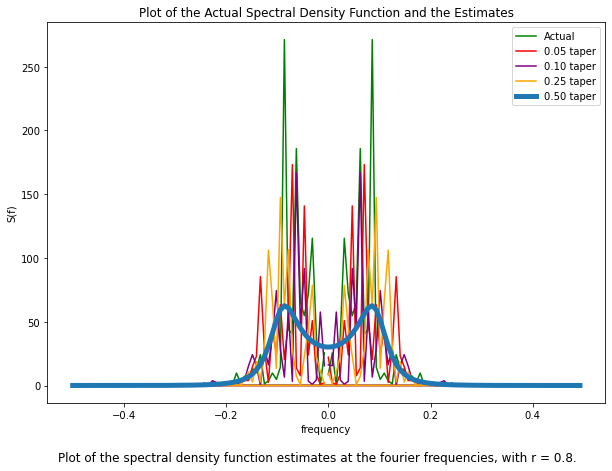

In [250]:
f_prime = 12/128
r = 0.8

plt.figure(figsize=(10, 7))

plt.plot([i/128 for i in range(64)] + [(-64+i)/128 for i in range(64)], direct(ARMA22_sim([2*r*cos(2*pi*f_prime), -r**2], [-0.5, -0.2], 1, 128), 0.05), color='green')
plt.plot([i/128 for i in range(64)] + [(-64+i)/128 for i in range(64)], direct(ARMA22_sim([2*r*cos(2*pi*f_prime), -r**2], [-0.5, -0.2], 1, 128), 0.10), color='red')
plt.plot([i/128 for i in range(64)] + [(-64+i)/128 for i in range(64)], direct(ARMA22_sim([2*r*cos(2*pi*f_prime), -r**2], [-0.5, -0.2], 1, 128), 0.25), color='purple')
plt.plot([i/128 for i in range(64)] + [(-64+i)/128 for i in range(64)], direct(ARMA22_sim([2*r*cos(2*pi*f_prime), -r**2], [-0.5, -0.2], 1, 128), 0.50), color='orange')

plt.plot([(i-64)/128 for i in range(128)], S_ARMA([(i-64)/128 for i in range(128)], 
                                                  [2*r*cos(2*pi*f_prime), -r**2], 
                                                  [-0.5, -0.2], 1), linewidth=5) # Plotted thick to ensure visibility.

plt.title('Plot of the Actual Spectral Density Function and the Estimates')
plt.xlabel('frequency')
plt.ylabel('S(f)')
plt.figtext(0.5, 0.01, 'Plot of the spectral density function estimates at the fourier frequencies, with r = 0.8.', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.legend(['Actual', '0.05 taper', '0.10 taper', '0.25 taper', '0.50 taper'])

We can see why the bias was so low for f = 60/128, since the actual and predicted spectral density functions are approximately 0. In addition, having run many simulations of the above plot, the green line (taper 0.05) and the orange line (taper 0.50) are consistently worse estimates for the lower frequencies (i.e. where the spectral density function is non-zero). Via these simulations, I believe the 0.25 taper provides the best estimate for the spectral density function.

## Question 2

In [12]:
import pandas as pd

data = pd.read_csv('/Users/macbook/Downloads/39.csv', header=None)

data

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-1.3417,-0.27515,1.0278,2.0483,1.5491,2.516,0.77254,-0.81683,-0.90346,-2.5471,...,-0.13811,-1.0462,-1.409,0.13372,-1.3603,-1.6609,0.17262,-1.0343,-0.25012,1.5152


2a

In [13]:
time_series_Q2 = []
for i in range(128):
    time_series_Q2.append(data[i][0]) # Make a list to work with the time series.

periodogram_Q2 = periodogram(time_series_Q2)
direct_Q2 = direct(time_series_Q2, 0.5)

Text(0, 0.5, 'S(f)')

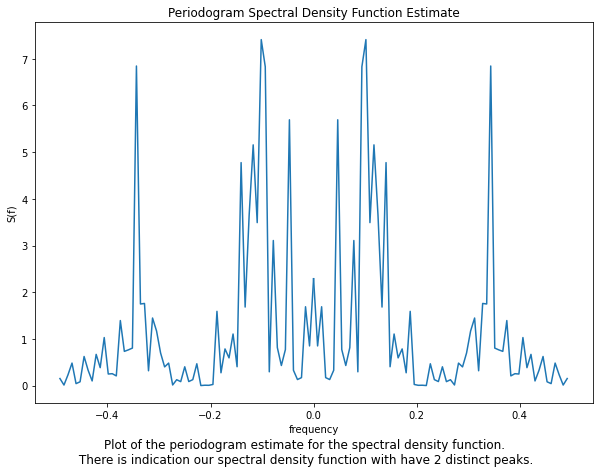

In [252]:
plt.figure(figsize=(10, 7))

plt.plot([i/128 for i in range(64)], periodogram_Q2[:64], color='tab:blue') + plt.plot([-i/128 for i in range(64)], periodogram_Q2[:64], color='tab:blue')
plt.title('Periodogram Spectral Density Function Estimate')
plt.figtext(0.5, 0.01, 'Plot of the periodogram estimate for the spectral density function.'
                       '\n There is indication our spectral density function with have 2 distinct peaks.', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.xlabel('frequency')
plt.ylabel('S(f)')

Text(0, 0.5, 'S(f)')

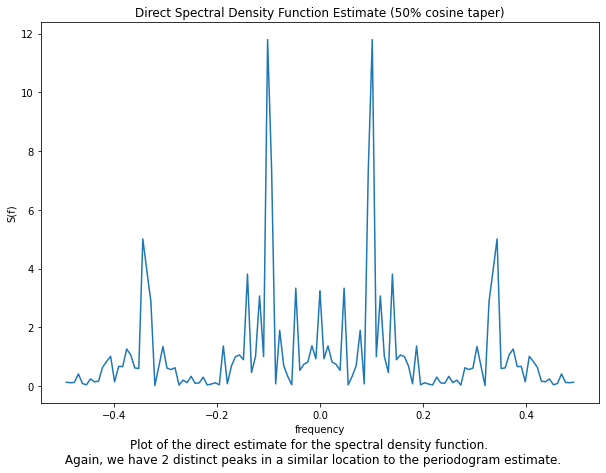

In [209]:
plt.figure(figsize=(10, 7))

plt.plot([i/128 for i in range(64)], direct_Q2[:64], color='tab:blue') + plt.plot([-i/128 for i in range(64)], direct_Q2[:64], color='tab:blue')
plt.title('Direct Spectral Density Function Estimate (50% cosine taper)')
plt.figtext(0.5, 0.01, 'Plot of the direct estimate for the spectral density function.'
                       '\n Again, we have 2 distinct peaks in a similar location to the periodogram estimate.', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.xlabel('frequency')
plt.ylabel('S(f)')

1b

In [220]:
from scipy import linalg

def YW_untapered(X, p):
    #Since we are told the time series' white noise has mean 0, we can use estimators for the autocovariance sequence, as discussed in lectures.
    acvs_estimate = []
    N = len(X)
    for i in range(p+1): # As the acvs is from 0 to p-1.
        acv = 0
        for j in range(N-i): # As from 1 to N-tao, accounting for python's indexing.
            acv += X[j] * X[j+i]
        acvs_estimate.append(acv/N)
    
    R = linalg.toeplitz(acvs_estimate[:p]) # We use the linalg module's toeplitz to solve the equation algebraically. 
    gamma = acvs_estimate[1:p+1]
    phi = linalg.inv(R).dot(gamma) # Matrix multiplication to give a vector of phis.
    
    sigma2 = acvs_estimate[0]
    for i in range(p):
        sigma2 -= phi[i] * acvs_estimate[i+1] # Calculating the sample variance for the process.
        
    return [phi, sigma2]

In [214]:
YW_untapered(time_series_Q2, 5) # Check the code runs correctly.

[array([ 0.39316058, -0.07152361,  0.21300015, -0.54706208,  0.00719513]),
 0.737366290497388]

Hence, we will have an AR(p) process, where the phi values are given b the phi array and the var of white noise is sigma2. it is assumed white noise is zero mean.

In [217]:
def YW_50tapered(X, p):
    acvs_estimate = []
    N = len(X)
    pN_floor = floor(0.5*N)
    h = []
    
    for i in range(1, floor(pN_floor/2) + 1): # Using the same formula as before.
        h.append(1/2 * (1 - cos((2*pi*(i))/(pN_floor + 1))))
    for i in range(floor(pN_floor/2) + 1, N + 1 - floor(pN_floor/2)):
        h.append(1) # Since we will have 1 * C.
    for i in range(N + 1 - floor(pN_floor/2), N + 1):
        h.append(1/2 * (1 - cos((2*pi*(N+1-i))/(pN_floor + 1))))
    
    sum_h_squared = sum(i*i for i in h)
    h = [i/sqrt(sum_h_squared) for i in h] # Normalising, as before.
    
    for i in range(p+1):
        acv = 0
        for j in range(N-i):
            acv += h[j] * X[j] * h[j+i] * X[j+i]
        acvs_estimate.append(acv) # No division by N since we have tapered.
    
    R = linalg.toeplitz(acvs_estimate[:p])
    gamma = acvs_estimate[1:p+1]
    phi = linalg.inv(R)@gamma # Matrix multiplication to give a vector of phis.
    
    sigma2 = acvs_estimate[0]
    for i in range(p):
        sigma2 -= phi[i] * acvs_estimate[i+1] # Calculating the sample variance for the process.
        
    return [phi, sigma2]

In [218]:
YW_50tapered(time_series_Q2, 5) # Check the code runs correctly.

[array([ 0.35592003, -0.05451747,  0.26436939, -0.53336517, -0.01165588]),
 0.7176766546761836]

In [219]:
def approx_MLE(X, p): # Using method 1 from the lectures to obtain a closed form approximate solution.
    N = len(X)
    F = np.array([[0 for i in range(p)]])
    for i in range(N-p):
        row = []
        for j in range(p):
            row.append(X[i - 1 + p - j]) # Appending rows to form the correct matrix.
        F = np.vstack([F, row])
    F = F[1:]
    X_bold = X[p:] # Since we only need Xp onwards for the calculation.
    
    phi = linalg.inv(F.T @ F) @ F.T @ X_bold # Using linalg's inverse function.
    
    sigma2 = ((X_bold - F@phi).T @ (X_bold - F@phi))/(N-p) # Note that this will give a biased estimator.
    
    return [phi, sigma2]

In [216]:
approx_MLE(time_series_Q2, 5) # Check the code runs correctly.

[array([ 0.37079872, -0.0543572 ,  0.23563167, -0.56290917, -0.00401996]),
 0.7029506293652175]

1c

In [221]:
from math import log
from tabulate import tabulate


aics = [['p', 'Yule-Walker (untapered)', 'Yule-Walker (50% cosine tapered)', 'Approximate Maximum Likelihood']]
N = len(time_series_Q2)

for i in range(1, 21):
    aic_p = [i]
    sigmas = [YW_untapered(time_series_Q2, i), YW_50tapered(time_series_Q2, i), approx_MLE(time_series_Q2, i)]
    for j in range(3):
        aic_p.append(2*i + N*log(sigmas[j][1])) # Append the AIC value for each method.
    aics.append(aic_p)
    
print(tabulate(aics, headers='firstrow', tablefmt='fancy_grid'))

╒═════╤═══════════════════════════╤════════════════════════════════════╤══════════════════════════════════╕
│   p │   Yule-Walker (untapered) │   Yule-Walker (50% cosine tapered) │   Approximate Maximum Likelihood │
╞═════╪═══════════════════════════╪════════════════════════════════════╪══════════════════════════════════╡
│   1 │                   8.23316 │                            4.47865 │                          7.19926 │
├─────┼───────────────────────────┼────────────────────────────────────┼──────────────────────────────────┤
│   2 │                   9.97405 │                            6.47243 │                          9.83398 │
├─────┼───────────────────────────┼────────────────────────────────────┼──────────────────────────────────┤
│   3 │                  11.9739  │                            7.21368 │                         11.7185  │
├─────┼───────────────────────────┼────────────────────────────────────┼──────────────────────────────────┤
│   4 │                 -30.

1d

Since we would like to use the value of p that produces the lowest AIC value, it is clear that for the Yule-Walker method, p = 6 and AIC = -31.6877. For the 50% cosine tapered Yule-Walker method, p = 4 and AIC = -34.4448. Finally, for maximum likelihood estimation, p = 6 and AIC = -41.0759. 

We have the following parameter values for phi and sigma2:

In [234]:
print(f'For the Yule-Walker method: phis = {YW_untapered(time_series_Q2, 6)[0]}, sigma2 = {YW_untapered(time_series_Q2, 6)[1]}')
print(f'For the 50% cosine tapered Yule-Walker method: phis = {YW_50tapered(time_series_Q2, 4)[0]}, sigma2 = {YW_50tapered(time_series_Q2, 4)[1]}')
print(f'For maximum likelihood estimation: phis = {approx_MLE(time_series_Q2, 6)[0]}, sigma2 = {approx_MLE(time_series_Q2, 6)[1]}')

For the Yule-Walker method: phis = [ 0.39179584  0.03224061  0.17259927 -0.53349581 -0.06737776  0.1896754 ], sigma2 = 0.7108382433551425
For the 50% cosine tapered Yule-Walker method: phis = [ 0.36218608 -0.05760675  0.26504085 -0.53758677], sigma2 = 0.717774171194245
For maximum likelihood estimation: phis = [ 0.36783214  0.03012933  0.19297787 -0.54979248 -0.06522027  0.18718123], sigma2 = 0.6605678008572667


1e

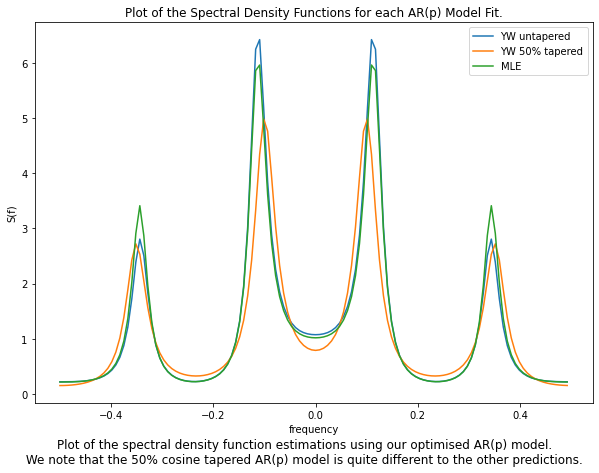

In [253]:
plt.figure(figsize=(10, 7))

plt.plot([(i-64)/128 for i in range(128)], S_ARMA([(i-64)/128 for i in range(128)], YW_untapered(time_series_Q2, 6)[0], [], YW_untapered(time_series_Q2, 6)[1]))
plt.plot([(i-64)/128 for i in range(128)], S_ARMA([(i-64)/128 for i in range(128)], YW_50tapered(time_series_Q2, 4)[0], [], YW_untapered(time_series_Q2, 4)[1]))
plt.plot([(i-64)/128 for i in range(128)], S_ARMA([(i-64)/128 for i in range(128)], approx_MLE(time_series_Q2, 6)[0], [], YW_untapered(time_series_Q2, 6)[1]))


plt.title('Plot of the Spectral Density Functions for each AR(p) Model Fit.')
plt.figtext(0.5, 0.01, 'Plot of the spectral density function estimations using our optimised AR(p) model.'
                       '\n We note that the 50% cosine tapered AR(p) model is quite different to the other predictions. ', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.xlabel('frequency')
plt.ylabel('S(f)')
plt.legend(['YW untapered', 'YW 50% tapered', 'MLE'])




## Question 3

3a

In [236]:
MLE_aic_p = []
time_series_Q3 = time_series_Q2[:118]

for i in range(1, 21): # Calculate the AIC for each value of p.
    sigma2 = approx_MLE(time_series_Q3, i)[1]
    MLE_aic_p.append(2*i + N*log(sigma2))
    
print(f"Hence, we will use p = {MLE_aic_p.index(min(MLE_aic_p)) + 1} for our model")

Hence, we will use p = 6 for our model


In [30]:
phi_params = approx_MLE(time_series_Q3, 6)[0]
phi_params

array([ 0.35565812,  0.02948263,  0.15312728, -0.52821608, -0.08029382,
        0.19199795])

In [237]:
X_array_Q3 = np.array(time_series_Q2[:-10]) # So we can do vector multiplication.
X_forecast = []

for i in range(10):
    X_t_i = sum(X_array_Q3[-6:] * phi_params) # Using the forecasting method discussed in lectures (i.e. setting future innovation terms = 0)
    X_forecast.append(X_t_i)
    X_array_Q3 = np.append(X_array_Q3, X_t_i)
    
actual = time_series_Q2[-10:] # The actual values for our prediction for the time series.

table = [['Xt', 'Actual', 'Forecast', 'Absolute Difference']]
for i in range(10): # Adding informative values to the table.
    row = [f"X{118+i}"]
    row.append(actual[i])
    row.append(X_forecast[i])
    row.append(abs(actual[i] - X_forecast[i]))
    table.append(row)
    
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))


╒══════╤══════════╤════════════╤═══════════════════════╕
│ Xt   │   Actual │   Forecast │   Absolute Difference │
╞══════╪══════════╪════════════╪═══════════════════════╡
│ X118 │ -0.13811 │  -1.10426  │              0.966152 │
├──────┼──────────┼────────────┼───────────────────────┤
│ X119 │ -1.0462  │  -0.216955 │              0.829245 │
├──────┼──────────┼────────────┼───────────────────────┤
│ X120 │ -1.409   │   0.808731 │              2.21773  │
├──────┼──────────┼────────────┼───────────────────────┤
│ X121 │  0.13372 │   1.2132   │              1.07948  │
├──────┼──────────┼────────────┼───────────────────────┤
│ X122 │ -1.3603  │   0.454696 │              1.815    │
├──────┼──────────┼────────────┼───────────────────────┤
│ X123 │ -1.6609  │  -0.669021 │              0.991879 │
├──────┼──────────┼────────────┼───────────────────────┤
│ X124 │  0.17262 │  -1.08109  │              1.25371  │
├──────┼──────────┼────────────┼───────────────────────┤
│ X125 │ -1.0343  │  -0.261571 

3b

In [240]:
MC_sim = []

for i in range(999):
    sim_i = []
    X_array_Q3b = np.array(time_series_Q2[:-10]) # The values we know, assuming we want to forecast.
    for j in range(10):
        X_t_j = sum(X_array_Q3b[-6:] * phi_params) + np.random.normal(0, 1) # We simulate the white noise process, since we are told it has var = 1.
        sim_i.append(X_t_j)
        X_array_Q3b = np.append(X_array_Q3b, X_t_j)
    MC_sim.append(sim_i)
    
sorted_vals = []
for i in range(10):
    sorted_val = []
    for j in range(999):
        sorted_val.append(MC_sim[j][i])
    sorted_val = sorted(sorted_val) # Sort the list in ascending order.
    sorted_vals.append(sorted_val)
    
fifty = []
nine_fifty = []
for i in range(10):
    fifty.append(sorted_vals[i][49])
    nine_fifty.append(sorted_vals[i][949])

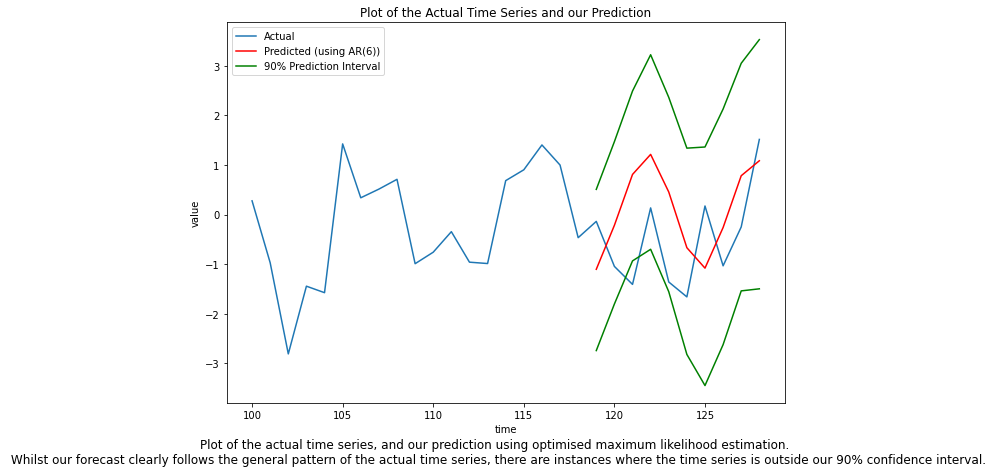

In [244]:
plt.figure(figsize=(10, 7))

plt.plot([i for i in range(100, 129)], time_series_Q2[99:])
plt.plot([i for i in range(119, 129)], X_forecast, color='red')
plt.plot([i for i in range(119, 129)], fifty, color='green')
plt.plot([i for i in range(119, 129)], nine_fifty, color='green')

plt.title('Plot of the Actual Time Series and our Prediction')
plt.figtext(0.5, 0.01, 'Plot of the actual time series, and our prediction using optimised maximum likelihood estimation. 
                       '\n Whilst our forecast clearly follows the general pattern of the actual time series, there are
                       'instances where the time series is outside our 90% confidence interval.', wrap=True, horizontalalignment='center', fontsize=12)

plt.xlabel('time')
plt.ylabel('value')
plt.legend(['Actual', 'Predicted (using AR(6))', '90% Prediction Interval'])